# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from os.path import join
from solver import Point, Facility, Customer, length, load_data
from vis import view_problem

In [3]:
path = 'data'
ls = os.listdir

In [4]:
# print(*ls(path),sep = '  ,  ')
for i,file in enumerate(ls(path)):
    customers, facilities = load_data(file)
    print(f'{file:15} {len(customers):6} Customers \t{len(facilities):6} Facilities')

fl_1000_2         1500 Customers 	  1000 Facilities
fl_1000_3         5000 Customers 	  1000 Facilities
fl_100_1          1000 Customers 	   100 Facilities
fl_100_10          100 Customers 	   100 Facilities
fl_100_11          500 Customers 	   100 Facilities
fl_100_12          500 Customers 	   100 Facilities
fl_100_13         1000 Customers 	   100 Facilities
fl_100_14          800 Customers 	   100 Facilities
fl_100_2          1000 Customers 	   100 Facilities
fl_100_3          1000 Customers 	   100 Facilities
fl_100_4          1000 Customers 	   100 Facilities
fl_100_5          1000 Customers 	   100 Facilities
fl_100_6           100 Customers 	   100 Facilities
fl_100_7           100 Customers 	   100 Facilities
fl_100_8           100 Customers 	   100 Facilities
fl_100_9           100 Customers 	   100 Facilities
fl_16_1             50 Customers 	    16 Facilities
fl_16_2             50 Customers 	    16 Facilities
fl_2000_2         2000 Customers 	  2000 Facilities
fl_2000_3   

In [82]:
customers, facilities = load_data('fl_50_1')
(customers, facilities)

([Customer(index=0, demand=146, location=Point(x=271151.005415, y=182500.375666)),
  Customer(index=1, demand=87, location=Point(x=271174.28298, y=182500.3671)),
  Customer(index=2, demand=672, location=Point(x=272653.448286, y=183068.675019)),
  Customer(index=3, demand=1337, location=Point(x=278615.098905, y=185792.50856)),
  Customer(index=4, demand=31, location=Point(x=271171.919808, y=182497.993964)),
  Customer(index=5, demand=559, location=Point(x=272088.833862, y=182850.845727)),
  Customer(index=6, demand=2370, location=Point(x=299498.08876, y=210542.997998)),
  Customer(index=7, demand=1089, location=Point(x=275150.105365, y=184336.62979)),
  Customer(index=8, demand=33, location=Point(x=271170.588171, y=182497.852906)),
  Customer(index=9, demand=32, location=Point(x=271172.866541, y=182498.087512)),
  Customer(index=10, demand=5495, location=Point(x=384981.479438, y=350758.465403)),
  Customer(index=11, demand=904, location=Point(x=273573.857303, y=183499.372217)),
  Custom

# Visualisation


In [5]:
from vis import view_problem, view_solution

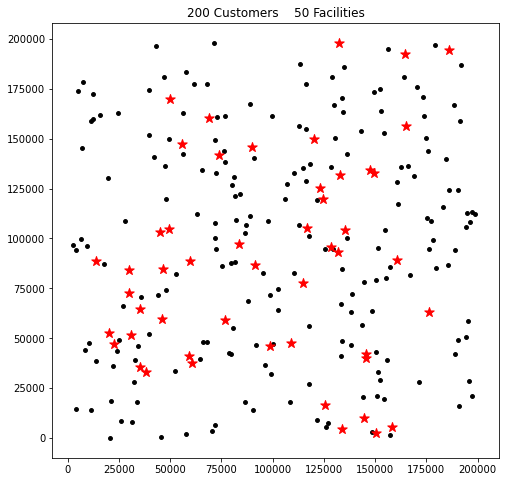

In [6]:
view_problem(customers,facilities)

In [95]:
sol = greedy(customers,facilities)

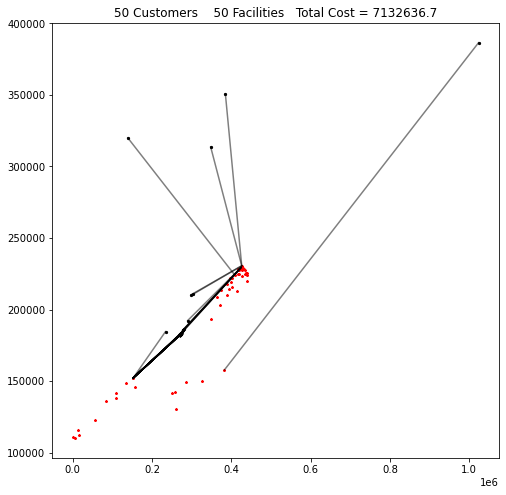

In [96]:
view_solution(sol,customers,facilities)

# Exploration

In [7]:
from calc import validate, total_cost

from algorithms import greedy
from exceptions import *

## Random allocation

In [48]:
from pdb import set_trace

In [251]:
from tqdm.auto import tqdm, trange
from joblib import Parallel, delayed


def random_allocation(customers, facilities):
    max_iter = 10000
    n_fac = len(facilities)
    allocations = -np.ones(len(customers))
    remaining_capacity = np.array([f.capacity for f in facilities])
    for i, customer in enumerate(customers):
        for counter in range(max_iter):
            selected_facility = np.random.choice(
                range(n_fac),
                p=remaining_capacity / remaining_capacity.sum(),
            )
            if remaining_capacity[selected_facility] >= customer.demand:
                remaining_capacity[selected_facility] -= customer.demand
                allocations[i] = selected_facility
                break
        else:
            raise IterationError('Maximum number of iterations reached.')
    return allocations.astype(int)


def ex_local_search(solution, customers, facilities, verbose=False):
    allocations = solution.copy()
    n_cutomers = len(customers)
    n_facilities = len(facilities)
    old_cost = total_cost(allocations, customers, facilities)
    pbar = trange(n_cutomers)
    for i in pbar:
        customer = customers[i]
        costs = np.zeros(n_facilities)
        old_alloc = allocations[i]
        for j in range(n_facilities):
            allocations[i] = j
            costs[j] = total_cost(allocations, customers, facilities)
        new_alloc = np.argmin(costs)
        allocations[i] = new_alloc
        if verbose:
            desc = '{:.1f} --> {:.1f} --> {:.1f}'.format(
                old_cost,
                costs[old_alloc],
                costs[new_alloc],
            )
            pbar.set_description(desc)
    return allocations


def ex_local_search(solution, customers, facilities, njobs=1):
    allocations = solution.copy()
    n_cutomers = len(customers)
    n_facilities = len(facilities)
    old_cost = total_cost(allocations, customers, facilities)
    pbar = trange(n_cutomers)
    for i in pbar:
        customer = customers[i]
        costs = np.zeros(n_facilities)
        old_alloc = allocations[i]

        parallel = Parallel(n_jobs=njobs)
        delayed_func = delayed(eval_swap_values)
        costs = parallel(
            delayed_func(
                allocations=allocations,
                customers=customers,
                facilities=facilities,
                customer=i,
                new_facility=j,
            ) for j in range(n_facilities))
        new_alloc = np.argmin(costs)
        allocations[i] = new_alloc
        desc = '{:.1f} --> {:.1f} --> {:.1f}'.format(
            old_cost,
            costs[old_alloc],
            costs[new_alloc],
        )
        pbar.set_description(desc)
    return allocations

def k_local_search(solution, customers, facilities, k = 5, njobs = 1):
    allocations = solution.copy()
    n_cutomers = len(customers)
    n_facilities = len(facilities)
    old_cost = total_cost(allocations, customers, facilities)
    pbar = trange(n_cutomers)
    for i in pbar:
        last_cost = total_cost(allocations, customers, facilities)
        customer = customers[i]
        costs = np.zeros(n_facilities)
        old_alloc = allocations[i]
        
        current_fac = solution[i]
        closest_facs = find_k_neighbors([facilities[current_fac]],facilities,k)[0]
        parallel = Parallel(n_jobs=njobs)
        delayed_func = delayed(eval_swap_values)
        costs = parallel(
            delayed_func(
                allocations=allocations,
                customers=customers,
                facilities=facilities,
                customer=i,
                new_facility=closest_facs[j],
            ) for j in range(k))
        new_alloc = closest_facs[np.argmin(costs)]
        allocations[i] = new_alloc
        desc = '{:.1f} --> {:.1f} --> {:.1f}'.format(
            old_cost,
            last_cost,
            min(costs),
        )
        pbar.set_description(desc)
    return allocations


def eval_swap_values(allocations, customers, facilities, customer,
                     new_facility):
    alloc = allocations.copy()
    alloc[customer] = new_facility
    return total_cost(alloc, customers, facilities)

def find_k_neighbors(x,y, k = 1):
    '''
    Finds k nearest neighbors for x in y. x and y are either Facilities or Customers,
    and must have location property.
    '''
    x = np.array([o.location for o in x])
    y = np.array([o.location for o in y])
    kdtree = KDTree(y)
    dist, neighbors = kdtree.query(x,k)
    return neighbors

In [225]:
from algorithms import greedy
from calc import total_cost

In [252]:
customers, facilities = load_data('fl_1000_2')
len(customers),len(facilities)

(1500, 1000)

In [249]:
# sol = random_allocation(customers,facilities)
sol = greedy(customers,facilities)
total_cost(sol,customers,facilities)

26899758.93936023

In [250]:
sol2 = k_local_search(sol,customers,facilities,12)

In [135]:
sol = greedy(customers,facilities)
total_cost(sol,customers,facilities)

26090682.612702664

In [136]:
sol2 = local_search(sol,customers,facilities,True)

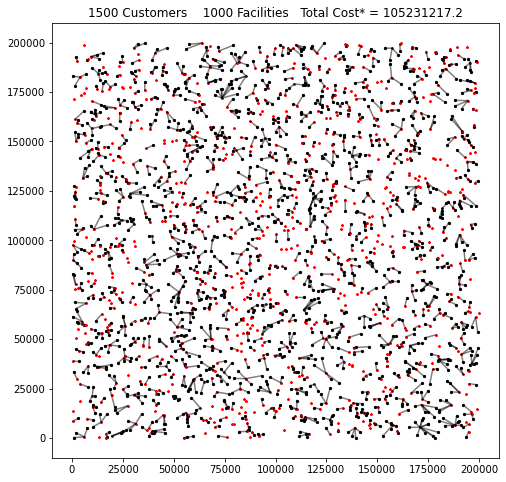

In [259]:
view_solution(sol2,customers,facilities)

In [141]:
validate(sol2,customers,facilities)

IndexError: list index out of range

## Constraint Programming

### Uncapacitated Facilities

In [174]:
from ortools.sat.python import cp_model
from calc import distance_matrix

In [146]:
customers,facilities= load_data('fl_100_1')
n_cust = len(customers)
n_fac = len(facilities)

In [164]:
caps = [f.capacity for f in facilities]
setup = [f.setup_cost for f in facilities]
dist = distance_matrix(customers,facilities).astype(int)
demands = [c.demand for c in customers]

In [147]:
model = cp_model.CpModel()

In [157]:
a = [] # allocation matrix (facilities x customers)
for f in range(n_fac):
    a.append([model.NewBoolVar(f'a_{c}_{f}') for c in range(n_cust)])

In [161]:
# Only one facility per customer
for c in range(n_cust):
    model.Add(sum([a[f][c] for f in range(n_fac)])==1)
    
# Capacity check
for f in range(n_fac):
    model.Add(sum([a[f][c]*demands[c] for c in range(n_cust)])<=caps[f])

In [165]:
obj = 0
for f in range(n_fac):
    for c in range(n_cust):
        obj+=a[f][c]*dist[f,c]

In [169]:
model.Minimize(obj)

In [170]:
cpsolver = cp_model.CpSolver()
cpsolver.parameters.max_time_in_seconds = 60.0
status = cpsolver.Solve(model)

In [175]:
STATUS = {
    cp_model.FEASIBLE: 'FEASIBLE',
    cp_model.UNKNOWN: 'UNKNOWN',
    cp_model.MODEL_INVALID: 'MODEL_INVALID',
    cp_model.INFEASIBLE: 'INFEASIBLE',
    cp_model.OPTIMAL: 'OPTIMAL',
}
STATUS[status]

'FEASIBLE'

In [176]:
values = [] # allocation matrix (facilities x customers)
for f in range(n_fac):
    values.append([cpsolver.Value(a[f][c]) for c in range(n_cust)])

values = np.array(values)

sol = values.argmax(axis=0)

In [183]:
total_cost(sol,customers,facilities)

135235944.1211516

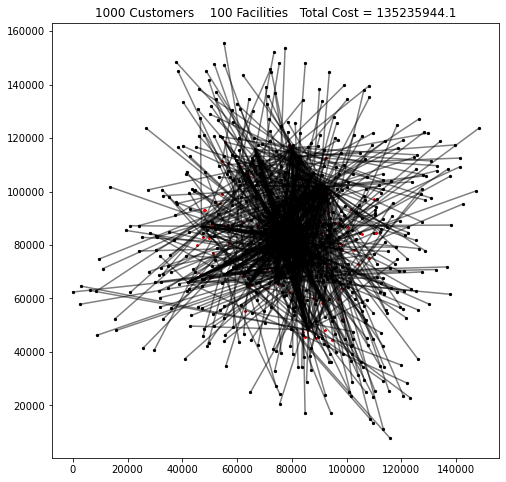

In [184]:
view_solution(sol,customers,facilities)

## Solve using clustering
Ignores the facility capital cost

In [34]:
import math
from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree
from calc import total_demand, total_cost
from tqdm.auto import trange

In [115]:
q = [2,3,5,3,1]

In [118]:
np.cumsum(sorted(q))

array([ 1,  3,  6,  9, 14], dtype=int32)

In [14]:
def est_facilities(customers, facilities):
    caps = [f.capacity for f in facilities]
    cumsum = np.cumsum(sorted(caps))
    demands = [c.demand for c in customers]
    total_demand = sum(demands)
    for i in range(len(facilities)):
        if cumsum[i]>=total_demand:
            print(f'Demand = {total_demand}, Capacity = {cumsum[i]}')
            return i+1
    
#     return math.ceil(total_demand/max(caps))

In [124]:
est_facilities(customers,facilities)

Demand = 50886, Capacity = 56000


7

In [149]:
customers, facilities = load_data('fl_1000_2')
n_cust = len(customers)
n_fac = len(facilities)
n_cust,n_fac

(1500, 1000)

In [150]:
[f.setup_cost for f in facilities]

[7318.4413,
 8788.0676,
 6958.9546,
 7317.1473,
 7463.9433,
 8215.2332,
 8472.1128,
 7800.1308,
 7549.7209,
 7634.6868,
 7023.5005,
 8054.5313,
 7146.7849,
 8536.3318,
 7765.8439,
 7479.0865,
 7696.0054,
 7487.6366,
 8400.2561,
 7547.0541,
 5936.7847,
 7410.7603,
 6031.4033,
 6729.6004,
 6907.8929,
 7315.5894,
 7728.1385,
 8824.6747,
 8945.9629,
 8571.1894,
 7124.8496,
 6366.9881,
 7778.7831,
 7973.2498,
 9215.7196,
 10204.2127,
 8431.6108,
 7440.4777,
 8612.0897,
 7222.1362,
 7693.1352,
 8298.6762,
 9161.3766,
 8251.8567,
 5671.4989,
 9627.6421,
 7523.5505,
 6566.1433,
 8305.1937,
 5911.5744,
 8921.6063,
 9589.8285,
 7866.0065,
 7863.3453,
 7976.9514,
 7220.8324,
 9171.2199,
 7921.4981,
 7393.578,
 7855.6247,
 8449.0664,
 8535.4546,
 8547.932,
 7756.1375,
 6253.1041,
 8646.843,
 7957.0807,
 8206.611,
 7912.7118,
 6913.5608,
 8177.3486,
 8413.3635,
 6598.7556,
 8471.0153,
 7287.3686,
 7952.3163,
 8139.2582,
 7255.1942,
 8006.5592,
 8557.4951,
 7938.5343,
 7494.5364,
 7149.149,
 7258.93

In [75]:
# total_demand(customers)

In [76]:
# [f.capacity for f in facilities]

In [140]:
def clustering(customers, facilities):
    n_cust = len(customers)
    n_fac = len(facilities)
    
    # Find minimum number of clusters
    min_fac = est_facilities(customers,facilities)
    
    # Find cluster centroids
    kmean = KMeans(min_fac)
    xy = np.array([c.location for c in customers])
    kmean.fit(xy)
    centroids = kmean.cluster_centers_
    
    # Find the distance between facilities and centroids
    fneigh = KDTree(np.array([f.location for f in facilities]))
    dist, locs = fneigh.query(centroids,min_fac)
    
    # Match facilities with centroids
    inactive_facs = set(range(n_fac))
    active_facs = []
    for i in range(min_fac):
        for j in range(min_fac):
            if locs[i,j] in inactive_facs:
                inactive_facs = inactive_facs - {locs[i,j]}
                active_facs.append(locs[i,j])
                break
    
    # Assign facilities to customers
    turn = 0
    remaining_cap = [facilities[f].capacity for f in active_facs]
    remaining_cust = set(range(n_cust))
    max_iter = len(active_facs)*n_cust
    sol = -np.ones(n_cust,dtype=int)
    pbar = trange(n_cust)
    for _ in range(max_iter):
        turn +=1
        turn %=len(active_facs)
        turn_fac = active_facs[turn]
        kd_cust = KDTree(np.array([customers[c].location for c in list(remaining_cust)]))
        dist, pot_cust = kd_cust.query([facilities[turn_fac].location],1)
        pot_cust = list(remaining_cust)[pot_cust[0][0]]
        if remaining_cap[turn]<customers[pot_cust].demand:
            continue
        else:
            pbar.update()
            sol[pot_cust] = turn_fac
            remaining_cust = remaining_cust - {pot_cust}
            remaining_cap[turn]-=customers[pot_cust].demand
        if min(sol)>=0:
            break
    else:
        IterationError('Maximum number of iteration reached.')
    return sol

In [141]:
sol = clustering(customers,facilities)

Demand = 50886, Capacity = 56000


In [142]:
sol

array([80, 91, 24, 66, 80, 24, 51, 38, 38, 91, 91, 80, 80, 80, 27, 51, 38,
       80, 80, 91, 24, 80, 66, 80, 80, 80, 66, 51, 24, 38, 51, 91, 80, 91,
       27, 24, 27, 38, 51, 66, 27, 80, 24, 51, 66, 51, 24, 27, 27, 38, 51,
       80, 51, 24, 80, 80, 51, 91, 91, 24, 27, 38, 91, 38, 66, 27, 51, 27,
       51, 91, 27, 38, 24, 27, 27, 51, 91, 38, 51, 27, 38, 80, 24, 80, 24,
       66, 66, 66, 24, 51, 51, 24, 80, 91, 80, 27, 66, 38, 80, 51, 24, 80,
       51, 80, 51, 38, 27, 80, 91, 80, 24, 24, 38, 66, 51, 27, 51, 66, 51,
       80, 91, 38, 24, 38, 24, 91, 66, 27, 51, 24, 27, 66, 27, 80, 24, 38,
       51, 24, 27, 80, 51, 66, 24, 80, 91, 66, 91, 24, 80, 51, 91, 24, 38,
       38, 51, 80, 38, 51, 27, 80, 66, 38, 24, 27, 66, 80, 24, 80, 80, 38,
       24, 27, 38, 91, 38, 24, 38, 66, 24, 80, 27, 24, 24, 66, 38, 91, 38,
       66, 38, 38, 24, 27, 91, 91, 51, 51, 66, 38, 38, 51, 51, 51, 80, 24,
       66, 24, 91, 27, 66, 38, 51, 91, 51, 51, 80, 91, 80, 91, 80, 91, 66,
       66, 66, 27, 38, 51

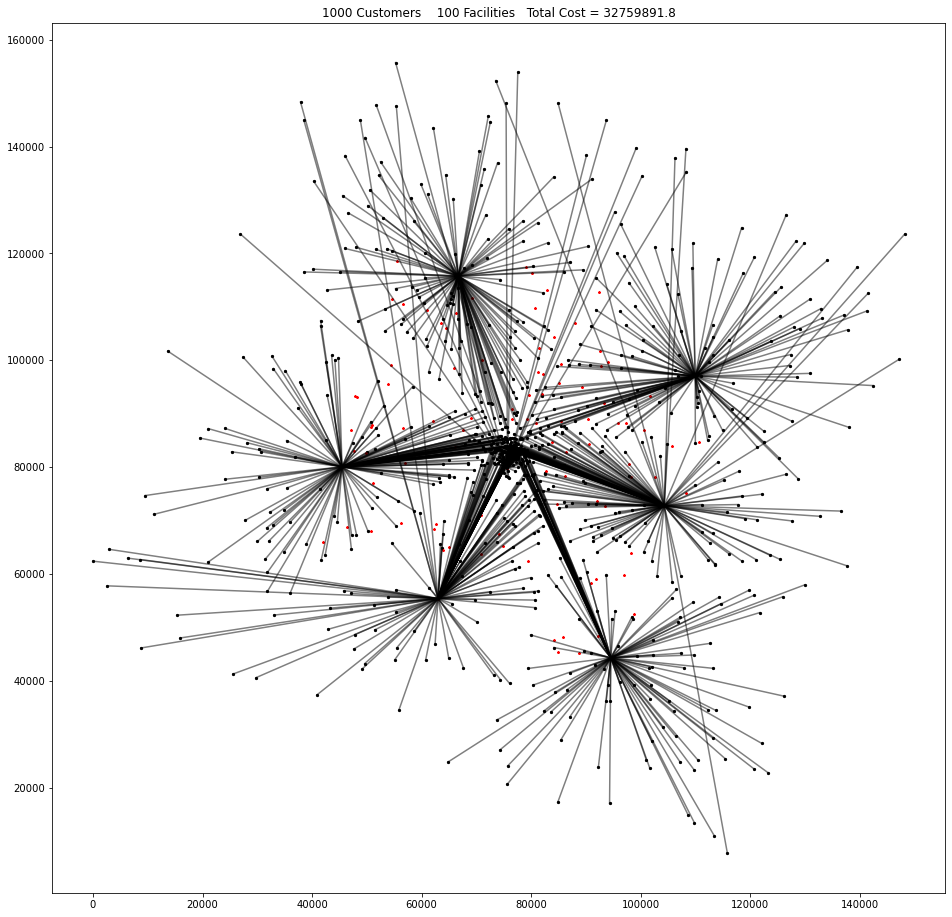

In [144]:
view_solution(sol,customers,facilities,(16,16))

## MIP

In [5]:
from ortools.linear_solver.pywraplp import Solver
from calc import distance_matrix, total_demand, est_facilities
from vis import view_problem, view_solution

In [6]:
from algorithms import uncap_mip_iter, clustering, cap_mip
from sklearn.neighbors import KDTree
from calc import diagnose, validate

In [570]:
customers, facilities = load_data('fl_25_2')
n_cust = len(customers)
n_fac = len(facilities)
n_cust,n_fac

(50, 25)

In [571]:
total_demand(customers)

58268

In [572]:
# facilities=facilities[:620]

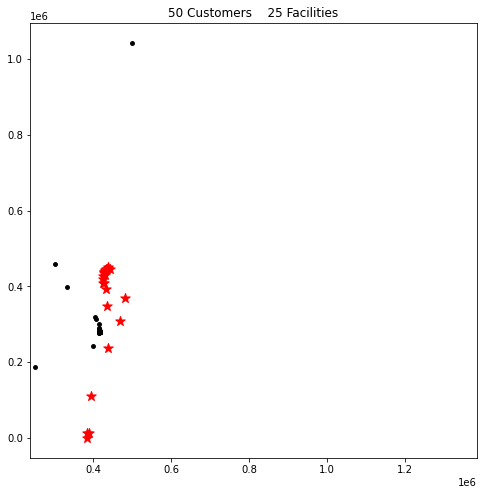

In [573]:
view_problem(customers,facilities)

In [208]:
est_facilities(customers,facilities)

Demand = 2513062, Capacity = 2514256


525

In [210]:
sol = uncap_mip(customers,facilities,120)

In [213]:
sol , status = sol

In [209]:
sol = uncap_mip_iter(customers,facilities)

Demand = 2513062, Capacity = 2514256


KeyboardInterrupt: 

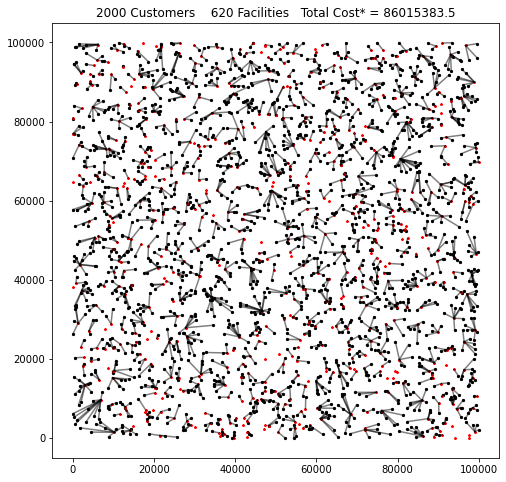

In [214]:
view_solution(sol,customers,facilities)

In [215]:
diagnose(sol,customers,facilities)

array([[    0, 10500,  4406, -6094],
       [    2,  8520,  3683, -4837],
       [    3,  3552,  4621,  1069],
       ...,
       [  615,  1283,  6372,  5089],
       [  618,  7575,  5856, -1719],
       [  619,  2813,  4713,  1900]], dtype=int64)

In [217]:
sol2 = fix_unfeasibles(sol, customers, facilities, max_iter = 1000)

Maximum iteration reached without finding a feasible solution.


In [174]:
diagnose(sol2, customers, facilities)

array([[      0, 1002968,    4463, -998505]], dtype=int64)

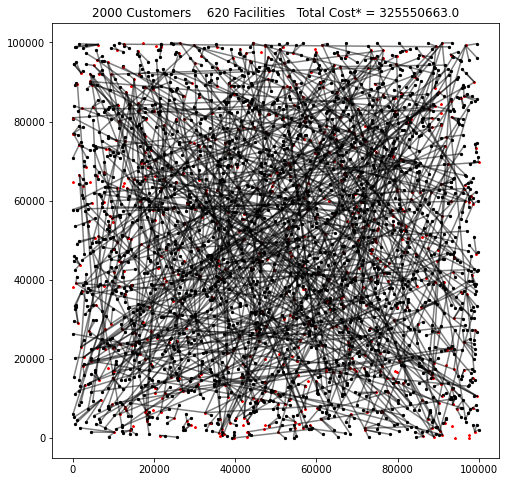

In [218]:
view_solution(sol2,customers,facilities)

In [165]:
from algorithms import ex_local_search_v2
sol3 = ex_local_search_v2(sol2,customers,facilities)

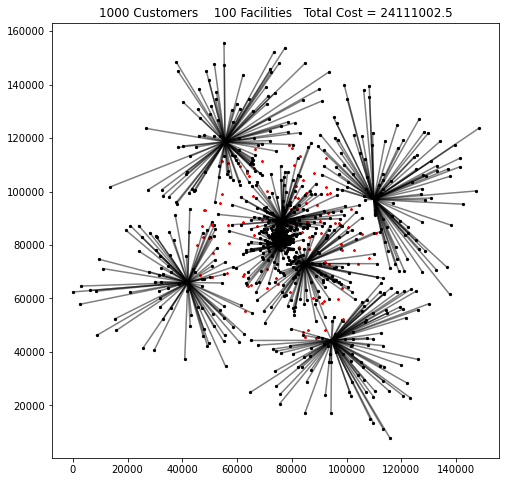

In [166]:
view_solution(sol3,customers,facilities)

In [140]:
cap_mip(customers,facilities)

(array([ 0, 29, 39, 25, 45,  0,  1, 44,  9,  0, 13, 42, 19,  4, 44, 19, 16,
        24, 28,  1, 29,  0, 42, 39,  8, 13,  1, 21, 40, 19, 24, 26, 49,  4,
        16, 27, 15,  9, 17, 32, 37, 40, 19, 21, 19,  6, 36, 36, 29,  3, 29,
        44,  4,  4, 35, 16,  9, 49,  4, 13, 22, 35,  5, 34,  5, 40, 46, 39,
         5, 14, 42, 45, 19, 19,  6,  6,  6, 44,  6,  6,  1, 29, 16,  6,  0,
        39, 22, 45,  7, 45,  7, 25, 31, 34, 29, 41, 23, 29, 31, 13, 47, 22,
        34,  8, 48, 21, 36,  5,  8, 47,  8,  9, 35, 23, 15, 13,  9, 39, 30,
        48, 35, 42, 14, 13, 48, 14,  9, 13, 33, 41, 40, 14, 28,  2, 41, 10,
        45,  4, 31, 36, 29, 28, 24, 22, 21, 28, 33, 11, 11,  8, 35, 11, 19,
        28, 11, 15, 16, 38, 43, 15, 12, 15,  6, 49, 31, 33, 13, 24, 26, 13,
         2, 11, 13, 35, 34, 22, 19, 49, 44, 12,  1,  2,  0, 37, 14,  9, 10,
        49, 47, 48,  9, 19, 15, 26, 11, 16, 15,  2, 16,  0], dtype=int64),
 'FEASIBLE')

In [142]:
q = _

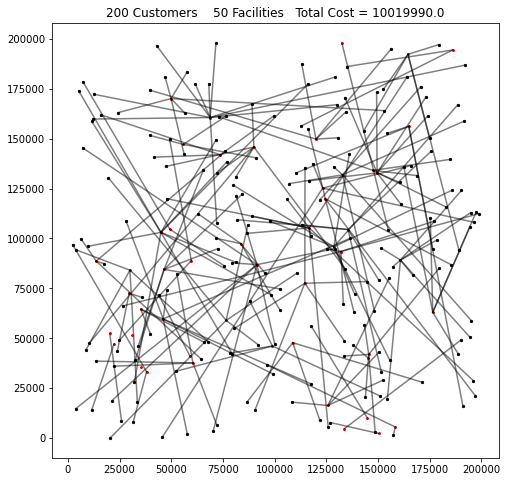

In [144]:
view_solution(q[0],customers,facilities)

In [119]:
def fix_unfeasibles(allocations, customers, facilities, max_iter = 100):
    allocations = np.array(allocations)
    loc_cust = np.array([c.location for c in customers])
    loc_fac = np.array([f.location for f in facilities])
    for i in range(max_iter):
        diag = diagnose(allocations, customers, facilities)
        idx = diag[:,0]
        spare = diag[:,3]
        f_worst = idx[spare.argmin()]
        f_best = idx[spare.argmax()]
        c_worst = np.where(allocations==f_worst)[0]
        kdtree = KDTree(loc_cust[c_worst,:])
        dist,target = kdtree.query([loc_fac[f_best,:]],1)
        allocations[c_worst[target]] = f_best
        try:
            validate(allocations, customers, facilities)
            break
        except AssertionError:
            continue
    else:
        print('Maximum iteration reached without finding a feasible solution.')
    return allocations

### Capacitated MIP

In [574]:
from algorithms import uncap_mip_iter, clustering, cap_mip
from solver import Facility, Customer
from calc import distance_matrix, min_facilities, est_facilities
from vis import view_problem, view_problem, problem_analysis

In [575]:
customers, facilities = load_data('fl_25_2')
est_facilities(customers,facilities)

1

In [576]:
min_facilities(customers,facilities)

1

In [762]:
def cap_mip2(customers,
             facilities,
             max_time=60,
             min_fac=None,
             max_fac=None,
             k_neigh=None):
    n_fac = len(facilities)
    n_cust = len(customers)
    solver = Solver.CreateSolver("FacilityLocation", "SCIP")
    if min_fac is None:
        min_fac = min_facilities(customers, facilities)
    print(f'Minimum Facilities: {min_fac}')
    est_fac = est_facilities(customers, facilities)
    est_fac = max(5, min_fac)
    print('Estimated Facilities:', est_fac)
    if k_neigh is None:
        k_neigh = n_fac // est_fac * 2
        k_neigh = min(k_neigh, n_fac // 2)
    print(f'Only using {k_neigh} nearest facilities')

    # Estimate Customers per Facilitiy
    cpf = n_cust // min_fac
    cpf = np.clip(cpf, 2, n_cust // 2)

    # Define Variables
    x = []
    y = []
    for f in range(n_fac):
        y.append([solver.BoolVar(f"y_{f}_{c}") for c in range(n_cust)])
        x.append(solver.BoolVar(f"x_{f}"))

    caps = np.array([f.capacity for f in facilities])
    setup = np.array([f.setup_cost * 100 for f in facilities])
    dist = distance_matrix(customers, facilities) * 100
    dist = dist.astype(int)
    demands = np.array([c.demand for c in customers])

    # Problem Analysis
    free_setup = np.where(caps == 0)[0]
    is_fixed_setup = True if np.std(caps[caps > 0]) == 0 else False

    # Add Constraints
    print('\t Adding Constaints')
    # If facility is closed then it is not connected to any customer
    for f in range(n_fac):
        for c in range(n_cust):
            solver.Add(y[f][c] <= x[f])

    # Each customer is connected to only one facility
    for c in range(n_cust):
        solver.Add(sum([y[f][c] for f in range(n_fac)]) == 1)

    # The demand is not more than the capacity of the facility
    for f in range(n_fac):
        solver.Add(
            sum([y[f][c] * demands[c]
                 for c in range(n_cust)]) <= caps[f] * x[f])
        solver.Add(
            sum([y[f][c] * demands[c] for c in range(n_cust)]) <= caps[f])

    # Customers per facility
    for f in range(n_fac):
        solver.Add(sum([y[f][c] for c in range(n_cust)]) <= n_cust * x[f])

    # The free facilities must be open
    for f in free_setup:
        solver.Add(x[f] == 1)

    # Customer can ONLY connect to nearby facilities
    for c in range(n_cust):
        idx = np.argsort(dist[:, c])
        for f in idx[k_neigh:]:
            solver.Add(y[f][c] == 0)

    print('\t Adding Covercut Constaints')
    # Cover cut for customers which can be connected to a facility
    #     round1 = []
    #     round2 = []
    #     for f in range(n_fac):
    #         argsort = np.argsort(dist[f, :])
    #         idx = argsort[:cpf]
    #         if sum(demands[idx]) > caps[f]:
    #             round1.append(f)
    #             solver.Add(sum([y[f][c] for c in idx]) <= (cpf - 1))
    #         if cpf > 4:
    #             k = int(cpf * .9)
    #             idx = argsort[:k]
    #             if sum(demands[idx]) > caps[f]:
    #                 round2.append(f)
    #                 solver.Add(sum([y[f][c] for c in idx]) <= (k - 1))

    #     print(round1)
    #     print(round2, flush=True)

    # Maximum Facility open
    solver.Add(sum(x) >= min_fac)
    if max_fac is not None:
        solver.Add(sum(x) <= max_fac)
    #     solver.Add(sum(x)>=2)

    # Define objective
    obj = 0
    for f in range(n_fac):
        # Setup cost
        if not is_fixed_setup:
            obj += setup[f] * x[f]
        # Service cost
        obj += sum([dist[f][c] * y[f][c] for c in range(n_cust)])
    solver.Minimize(obj)

    STATUS = {
        Solver.FEASIBLE: "FEASIBLE",
        Solver.UNBOUNDED: "UNBOUNDED",
        Solver.BASIC: "BASIC",
        Solver.INFEASIBLE: "INFEASIBLE",
        Solver.NOT_SOLVED: "NOT_SOLVED",
        Solver.OPTIMAL: "OPTIMAL",
    }
    solver.SetTimeLimit(max_time * 1000)

    # Solve
    print('\t Starting the Solver')
    status = solver.Solve()
    STATUS[status]

    # Retreive values
    a = []
    for f in range(n_fac):
        a.append([y[f][c].solution_value() for c in range(n_cust)])

    # Convert solution matrix to facility index
    sol = np.array(a).argmax(axis=0)

    return sol, STATUS[status]


def find_max_customers(capacity, demands):
    if capacity >= np.sum(demands):
        return len(demands)
    sorted_demands = np.array(sorted(demands))
    cumsum_demands = sorted_demands.cumsum()
    loc = np.searchsorted(cumsum_demands > capacity, .5)
    return loc - 1

In [763]:
customers, facilities = load_data('fl_25_2')
n_cust = len(customers)
n_fac = len(facilities)
n_cust,n_fac

(50, 25)

In [768]:
problem_analysis(customers,facilities,False)

Customers: 10
Facilities: 25
Total Demand: 6356
Minimum = 31 	 Maximum = 2370
Total Capacity: 1456700
Minimum = 58268 	 Maximum = 58268
Minimum Facilities Required: 1


In [765]:
est_facilities(customers,facilities)

1

In [770]:
sol, status = cap_mip2(customers[:20],facilities,120,k_neigh=20,max_fac=20)
print(status)

Minimum Facilities: 1
Estimated Facilities: 5
Only using 20 nearest facilities
	 Adding Constaints
	 Adding Covercut Constaints
	 Starting the Solver
FEASIBLE


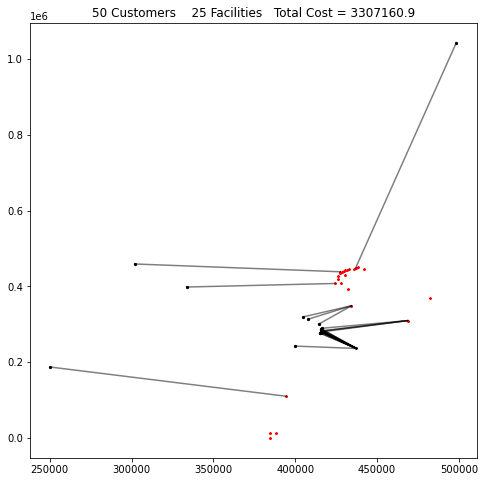

In [767]:
view_solution(sol,customers,facilities)

In [126]:
diagnose(sol,customers,facilities)

array([[   0, 2468, 4765, 2297],
       [   1, 2602, 4800, 2198],
       [   2, 1947, 5543, 3596],
       [   3, 4259, 5016,  757],
       [   4, 1504, 4924, 3420],
       [   5, 4395, 4775,  380],
       [   6, 2597, 5099, 2502],
       [   7, 4269, 4879,  610],
       [   8, 4740, 5702,  962],
       [   9, 6038, 6183,  145],
       [  10, 3965, 5156, 1191],
       [  11, 3989, 5699, 1710],
       [  12,  761, 3467, 2706],
       [  13, 1809, 4826, 3017],
       [  14, 2725, 4522, 1797],
       [  15, 2916, 4471, 1555],
       [  17, 4208, 5426, 1218],
       [  18, 3098, 4633, 1535],
       [  19,  724, 6794, 6070],
       [  20, 4918, 5302,  384],
       [  23, 2353, 4483, 2130],
       [  26, 4317, 4562,  245],
       [  35, 4818, 5759,  941],
       [  38, 1197, 4535, 3338],
       [  41, 3197, 5728, 2531]], dtype=int64)

## KNN Search

In [260]:
from calc import distance_matrix, total_demand, est_facilities
from vis import view_problem, view_solution
from algorithms import uncap_mip_iter, clustering
from sklearn.neighbors import KDTree
from calc import diagnose, validate

In [305]:
customers, facilities = load_data('fl_2000_2')
n_cust = len(customers)
n_fac = len(facilities)
n_cust,n_fac

(2000, 2000)

In [306]:
total_demand(customers)

2513062

In [307]:
est_facilities(customers, facilities)

Demand = 2513062, Capacity = 2515484


616

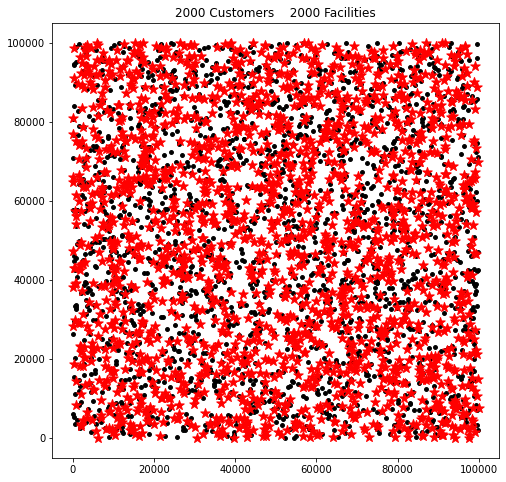

In [308]:
view_problem(customers,facilities)

In [309]:
sol = find_k_neighbors(customers,facilities,1)

In [310]:
sol = sol[:,0]

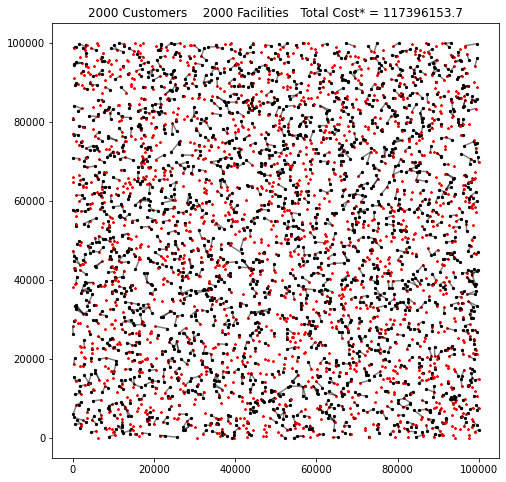

In [311]:
view_solution(sol,customers,facilities)

In [312]:
len(set(sol.flatten()))

1196

In [313]:
sol2 = k_local_search(sol,customers,facilities)

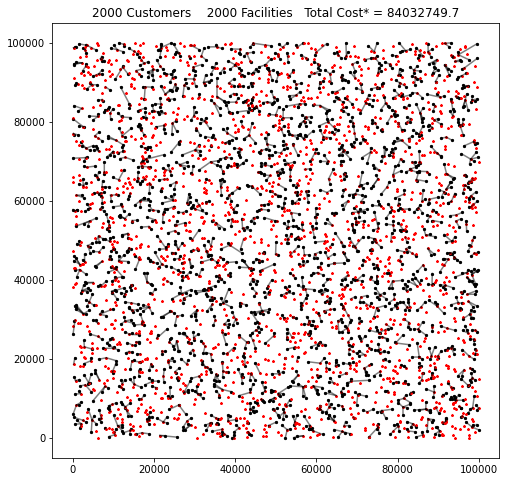

In [314]:
view_solution(sol2,customers,facilities)

Customers: 50
Facilities: 25


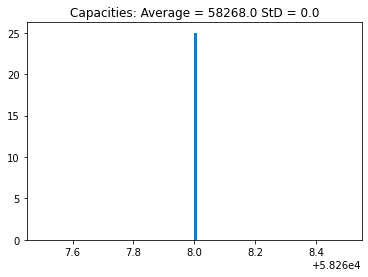

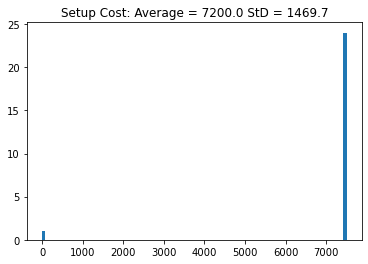

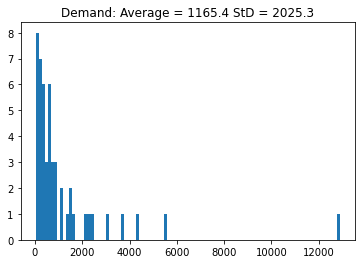

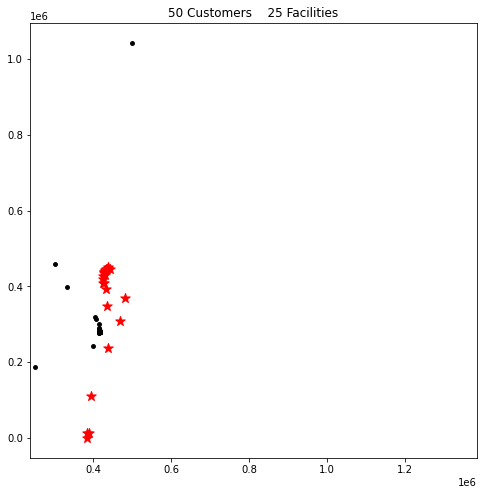

In [360]:
problem_analysis(customers,facilities)

## Greedy Furthest Point

In [589]:
from calc import distance_matrix, total_demand, est_facilities,total_cost
from vis import view_problem, view_solution
from algorithms import uncap_mip_iter, clustering, greedy
from sklearn.neighbors import KDTree
from calc import diagnose, validate
from algorithms import greedy_furthest, double_trial
from tqdm.auto import tqdm

In [586]:
customers, facilities = load_data('fl_200_7')
n_cust = len(customers)
n_fac = len(facilities)
n_cust,n_fac

(800, 200)

In [139]:
total_demand(customers)

58268

In [140]:
est_facilities(customers, facilities)

1

In [141]:
dist = distance_matrix(customers,facilities)

In [142]:
n_fac, n_cust

(25, 50)

In [143]:
dist.shape

(25, 50)

In [168]:
solution = greedy_furthest(customers,facilities)

In [587]:
#1  fl_25_2
#2  fl_50_6
#3  fl_100_7
#4  fl_100_1
#5  fl_200_7
#6  fl_500_7
#7  fl_1000_2
#8  fl_2000_2
customers, facilities = load_data('fl_500_7')
n_cust = len(customers)
n_fac = len(facilities)
print(n_cust,n_fac)
solution = double_trial(customers,facilities,greedy_furthest,p_skip=0.2)
total_cost(solution,customers,facilities)

3000 500


33744956.22941698

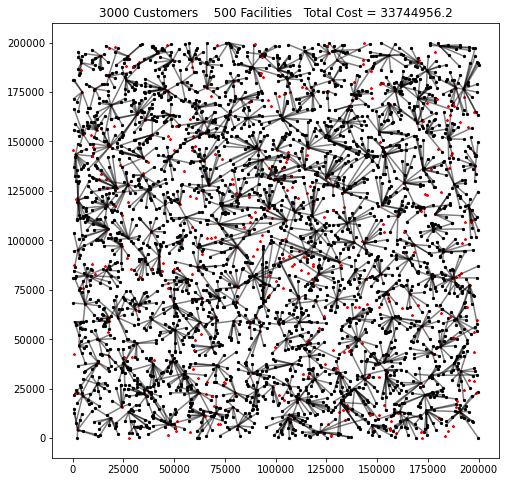

In [588]:
view_solution(solution,customers,facilities)

In [591]:
solution = greedy(customers,facilities)
total_cost(solution,customers,facilities)

70150556.8710001

In [592]:
solution = clustering(customers,facilities)
total_cost(solution,customers,facilities)

37067996.8640193

## Greedy Furthest on Subset

In [1]:
from calc import distance_matrix, total_demand, est_facilities,total_cost
from vis import view_problem, view_solution
from algorithms import uncap_mip_iter, clustering
from sklearn.neighbors import KDTree
from calc import diagnose, validate
from algorithms import greedy_furthest, double_trial
from tqdm.auto import tqdm, trange

In [377]:
#1  fl_25_2
#2  fl_50_6
#3  fl_100_7
#4  fl_100_1
#5  fl_200_7
#6  fl_500_7
#7  fl_1000_2
#8  fl_2000_2

In [562]:
customers, facilities = load_data('fl_100_1')
n_cust = len(customers)
n_fac = len(facilities)
print(n_cust,n_fac)

1000 100


In [563]:
solution = greedy_furthest(customers,facilities,p_skip=0,pbar=False)
total_cost(solution,customers,facilities)

178669106.39934862

In [564]:
solution = double_trial(customers,facilities,greedy_furthest,p_skip=0,pbar=False)
total_cost(solution,customers,facilities)

24300907.635547794

In [565]:
est_facs = est_facilities(customers,facilities)
print(est_facs)
n_trials = 10000
weights = np.ones(n_fac)
q = 2e7
evap = .02
offset = 2e7

7


In [566]:
costs = []
for i in trange(n_trials):
    probs = weights/weights.sum()
    idx = np.random.choice(range(n_fac),size=est_facs,replace=False,p=probs)
    selection = [facilities[f] for f in idx ]
    solution = greedy_furthest(customers,selection,pbar=False)
    solution = [idx[f] for f in solution]
    new_weights = np.array([1 if f in solution else 0 for f in range(n_fac)])
    cost = total_cost(solution, customers,facilities)
    costs.append(cost)
    weights = weights*(1-evap) + q*new_weights/(cost-offset)

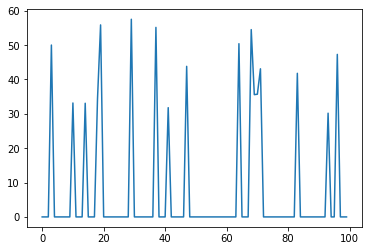

In [567]:
plt.plot(weights)

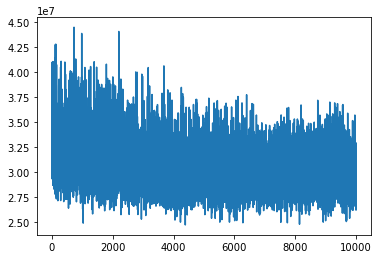

In [568]:
plt.plot(costs)

In [569]:
total_cost(solution, customers,facilities)

30410327.27143589

## Ant Colony

In [434]:
from collections import defaultdict

In [484]:
def ant_simulator(customers, facilities, distances, probabilities):
    n_cust = len(customers)
    n_fac = len(facilities)
    solution = -np.ones(n_cust)
    opened_fac = np.zeros(n_fac)
    remaining_cap = np.array([f.capacity for f in facilities])
    setup_cost = np.array([f.setup_cost for f in facilities])
    dist_ord = distances.mean(axis=0).argsort()
    for c in reversed(dist_ord):
        customer = customers[c]
        choice_prob = probabilities[:, c]
        choice_prob[remaining_cap < customer.demand] = 0
        choice_prob /= choice_prob.sum()
        f = np.random.choice(range(n_fac), p=choice_prob)
        solution[c] = f
    return solution.astype(int)


def ant_colony(
    customers,
    facilities,
    q=1,
    offset=0,
    evaporation=.1,
    ants=100,
    generations=100,
):
    n_cust = len(customers)
    n_fac = len(facilities)
    dist = distance_matrix(customers, facilities)
    weights = np.ones_like(dist)
    best_sol = None
    best_cost = np.inf
    metrics = defaultdict(list)
    greedy_solution = double_trial(
        customers,
        facilities,
        greedy_furthest,
        p_skip=0,
        pbar=False,
    )
    for gen in trange(generations):
        probs = weights/dist
        updates = np.zeros_like(dist)
        costs = []
        for ant in range(ants):
            if ant==0:
                solution = greedy_solution.copy()
            else:
                solution = ant_simulator(customers, facilities, dist, probs)
            cost = total_cost(solution,customers, facilities)
            edges = allocation2matrix(solution, n_fac)
            updates += edges*q/(cost-offset)
            costs.append(cost)
            if cost<best_cost:
                best_cost = cost
                best_sol = solution
                
        weights = weights*(1-evaporation) + updates
        metrics['min_cost'].append(np.min(costs))
        metrics['max_cost'].append(np.max(costs))
        metrics['mean_cost'].append(np.mean(costs))
    return best_sol, metrics

def allocation2matrix(allocations, n_facilities):
    matrix = np.eye(n_facilities)
    return matrix[np.array(allocations)].T

In [485]:
customers, facilities = load_data('fl_200_7')
n_cust = len(customers)
n_fac = len(facilities)
print(n_cust,n_fac)

800 200


In [489]:
solution = double_trial(
    customers,
    facilities,
    greedy_furthest,
    p_skip=0,
    pbar=False,
)
cost = total_cost(solution, customers, facilities)
q = cost/10
offset = cost * .75
s, m = ant_colony(
    customers,
    facilities,
    q=q,
    offset=offset,
    evaporation=.05,
    generations=200,
)

In [490]:
total_cost(s,customers,facilities)

5430908.857997433

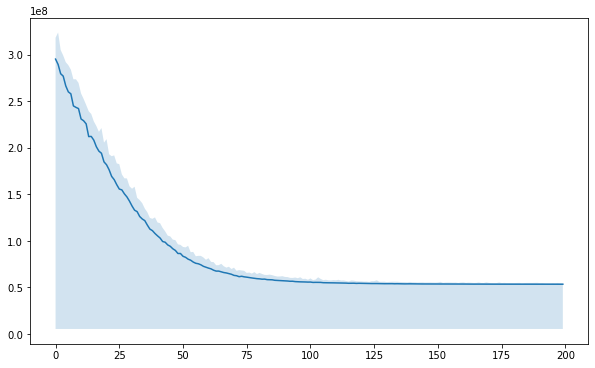

In [491]:
plt.figure(figsize=(10, 6))
n = len(m['min_cost'])
plt.fill_between(range(n), m["min_cost"], m["max_cost"], alpha=0.2)
plt.plot(range(n), m["mean_cost"])

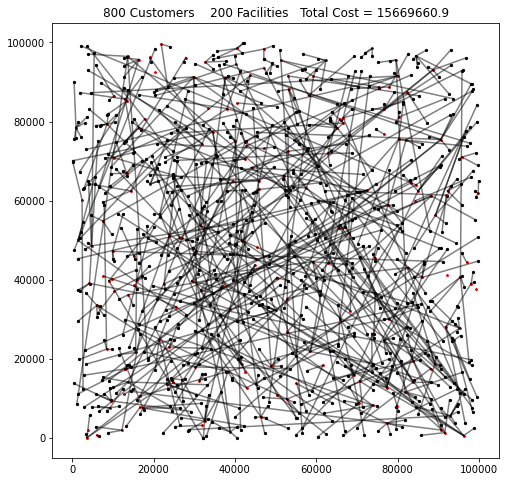

In [470]:
view_solution(s,customers,facilities)

In [447]:
print(f'{total_cost(s,customers,facilities):.2f}', 0)
print(' '.join([str(o) for o in s]))

204806524.41 0
5 42 94 50 1 98 1 37 88 95 47 51 96 81 61 26 25 14 39 26 71 94 49 14 60 67 16 49 63 15 53 93 69 80 25 4 27 6 10 50 24 67 85 67 84 69 62 22 4 98 86 14 31 72 42 8 51 32 75 51 65 45 43 83 99 50 78 59 12 32 3 51 69 67 93 75 57 22 37 40 81 58 83 25 37 66 57 55 80 33 64 4 64 60 13 84 43 75 47 51 41 48 16 46 11 1 94 9 64 89 6 51 82 44 51 39 12 59 10 54 89 6 93 70 64 20 66 21 57 60 70 25 14 46 24 25 96 85 4 20 39 44 51 7 74 99 51 5 76 51 46 30 51 24 49 97 65 51 3 47 37 85 8 67 94 96 23 18 19 94 36 94 60 21 99 23 99 15 64 47 73 64 81 60 59 60 53 81 53 75 49 88 90 39 12 8 75 81 76 79 37 50 60 16 59 29 20 32 17 93 7 89 48 99 42 65 35 36 59 43 59 91 68 79 83 14 20 74 49 1 44 72 27 23 1 1 63 82 17 8 32 61 51 70 62 54 95 84 64 26 72 37 2 18 73 40 64 14 74 47 25 29 85 81 74 26 51 80 89 44 46 58 43 44 90 71 55 84 26 17 24 23 54 5 67 79 90 75 91 68 58 12 54 36 87 41 88 35 50 53 36 15 60 59 40 9 94 47 38 36 92 26 51 45 7 94 64 33 50 44 45 46 99 5 22 85 61 11 93 20 38 81 57 32 37 45 85 64 

In [433]:
dist.shape

(100, 1000)

In [426]:
solution

[64,
 71,
 57,
 38,
 71,
 38,
 69,
 71,
 69,
 71,
 91,
 69,
 64,
 71,
 69,
 91,
 69,
 69,
 64,
 91,
 69,
 69,
 71,
 57,
 69,
 69,
 71,
 69,
 85,
 57,
 57,
 71,
 91,
 91,
 64,
 69,
 64,
 38,
 69,
 57,
 85,
 91,
 69,
 71,
 71,
 71,
 69,
 91,
 64,
 38,
 69,
 57,
 69,
 69,
 69,
 69,
 69,
 71,
 71,
 69,
 69,
 38,
 71,
 38,
 57,
 91,
 71,
 85,
 69,
 91,
 69,
 38,
 69,
 57,
 85,
 69,
 91,
 38,
 69,
 69,
 38,
 91,
 38,
 64,
 69,
 57,
 71,
 57,
 85,
 71,
 69,
 38,
 64,
 71,
 91,
 91,
 38,
 57,
 57,
 69,
 69,
 64,
 69,
 91,
 71,
 71,
 64,
 91,
 91,
 91,
 64,
 57,
 69,
 57,
 69,
 64,
 69,
 71,
 69,
 57,
 71,
 69,
 69,
 38,
 64,
 91,
 71,
 64,
 71,
 69,
 64,
 38,
 69,
 69,
 57,
 38,
 69,
 85,
 64,
 91,
 71,
 57,
 69,
 71,
 91,
 57,
 71,
 69,
 64,
 69,
 71,
 69,
 69,
 38,
 71,
 91,
 69,
 69,
 69,
 71,
 57,
 57,
 69,
 64,
 71,
 57,
 38,
 64,
 64,
 69,
 85,
 85,
 71,
 91,
 38,
 71,
 71,
 57,
 85,
 57,
 64,
 85,
 69,
 57,
 57,
 91,
 57,
 57,
 38,
 38,
 71,
 64,
 57,
 71,
 69,
 69,
 57,
 38,
 71,
 69,


In [418]:
dist = distance_matrix(customers,facilities)

## Greedy with restarts

In [5]:
from calc import distance_matrix, total_demand, est_facilities,total_cost
from vis import view_problem, view_solution
from algorithms import uncap_mip_iter, clustering
from sklearn.neighbors import KDTree
from calc import diagnose, validate
from algorithms import greedy_furthest, double_trial
from tqdm.auto import tqdm, trange

In [524]:
#1  fl_25_2
#2  fl_50_6
#3  fl_100_7
#4  fl_100_1
#5  fl_200_7
#6  fl_500_7
#7  fl_1000_2
#8  fl_2000_2

In [558]:
customers, facilities = load_data('fl_200_7')
n_cust = len(customers)
n_fac = len(facilities)
print(n_cust,n_fac)

800 200


In [559]:
def iter_greedy(customers,facilities,branches = 5,random_state=None):
    np.random.seed(random_state)
    solution = greedy_furthest(customers,facilities,pbar=False)
    cost = total_cost(solution, customers, facilities)
    for _ in range(len(facilities)):
        idx = np.random.choice(np.unique(solution),5)
#         new_facilities = [f for f in facilities if f.index!=dropped_facility]
        old_facilities = facilities.copy()
        new_sols = []
        new_costs = []
        for i in idx:
            facilities = old_facilities.copy()
            dropped_facility = facilities.pop(i)
            new_sols.append( greedy_furthest(customers,facilities,pbar=False))
            new_costs.append( total_cost(new_sols[-1], customers, facilities))
        if min(new_costs)<cost:
            i = np.argmin(new_costs)
            solution = new_sols[i]
            cost = new_costs[i]
        else:
            return [old_facilities[f].index for f in solution]
            
            
def greedy_restart(customers,facilities,restarts=100,branches = 5,random_state=None):
    best_sol = []
    best_cost = np.inf
    pbar = trange(restarts)
    for _ in pbar:
        pbar.set_description(f'{best_cost:.1f}')
        solution = iter_greedy(customers,facilities,branches,random_state)
        cost = total_cost(solution,customers,facilities)
        if cost<best_cost:
            best_cost = cost
            best_sol = solution
    return best_sol



In [560]:
sol = iter_greedy(customers,facilities,20)

In [561]:
solution = greedy_restart(customers,facilities,100,10)

In [551]:
total_cost(_,customers,facilities)

5723509.441606937

Customers: 1000
Facilities: 67
Total Demand: 50886
Minimum = 1 	 Maximum = 100
Total Capacity: 536000
Minimum = 8000 	 Maximum = 8000
Minimum Facilities Required: 7


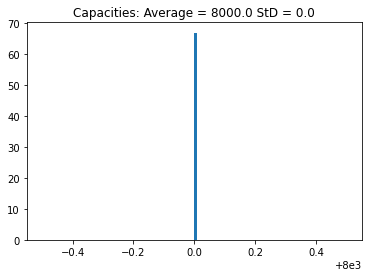

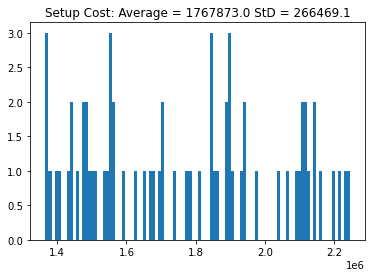

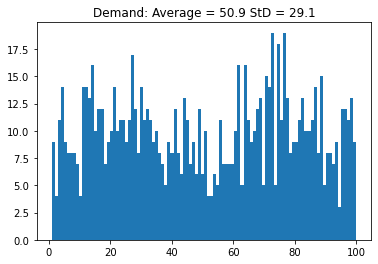

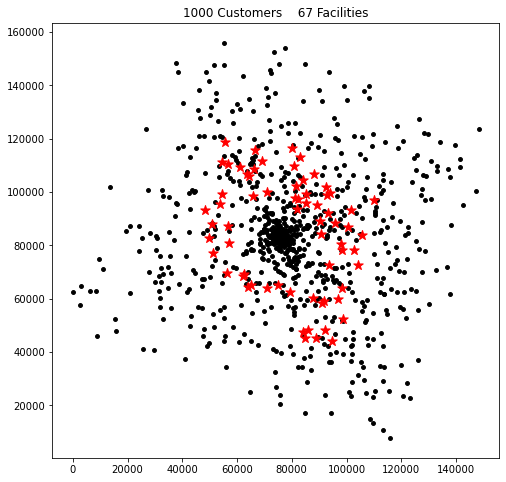

In [528]:
problem_analysis(customers,facilities)

## Local Search


In [645]:
from algorithms import ex_local_search, k_local_search, greedy_furthest,double_trial

In [524]:
#1  fl_25_2
#2  fl_50_6
#3  fl_100_7
#4  fl_100_1
#5  fl_200_7
#6  fl_500_7
#7  fl_1000_2
#8  fl_2000_2

In [710]:
customers, facilities = load_data('fl_500_7')
n_cust = len(customers)
n_fac = len(facilities)
print(n_cust,n_fac)

3000 500


In [706]:
from random import shuffle


38396856.08520833


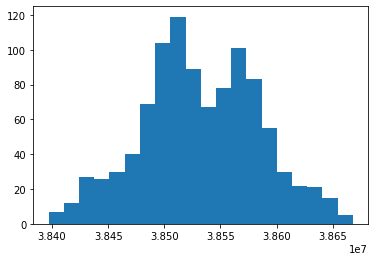

In [712]:
costs = []
order = np.arange(n_cust)
np.random.shuffle(order)
for i in trange(1000):
    
    solution = greedy_furthest(
        customers,
        facilities,
        ignore_setup=True,
        pbar=False,
        order=order,
    )
    cost = total_cost(solution, customers, facilities)
    costs.append(cost)
    
    idx = np.argsort(solution)
    groups = defaultdict(list)
    for c, f in enumerate(solution):
        groups[f].append(c)
    groups[-1] = [f for f in range(len(facilities)) if f not in solution]
    for f in groups.keys():
        shuffle(groups[f])
    groups = list(groups.values())
    shuffle(groups)
    order = sum(groups,start=[])
print(min(costs))
plt.hist(costs,bins=20);

In [709]:
solution  = greedy_furthest(customers,facilities,ignore_setup=False,pbar=False)
cost = total_cost(solution,customers,facilities)
print(cost)

10791290.104934987


In [626]:
solution  = double_trial(customers,facilities,greedy_furthest,ignore_setup=False,pbar=False)
cost = total_cost(solution,customers,facilities)
print(cost)

10791290.104934987


In [627]:
solution  = double_trial(customers,facilities,greedy_furthest,ignore_setup=True,pbar=False)
cost = total_cost(solution,customers,facilities)
print(cost)

10858345.13548881


In [603]:
for i in range(10):
    sol2 = k_local_search(solution,customers,facilities,k=10)
    cost2 = total_cost(sol2,customers,facilities)
    if cost2==cost:
        print('No improvement was observed')
        break
    else:
        solution = sol2
        cost = cost2


No improvement was observed


# MIP Gurobi

In [94]:
from itertools import product
from math import sqrt
from calc import diagnose, total_cost
import gurobipy as gp
from gurobipy import GRB
from solver import load_data

In [95]:
def cap_mip_gr(customers,facilities,max_time = 60):
    n_cust = len(customers)
    n_fac = len(facilities)
    dist = distance_matrix(customers, facilities)
    cartesian_prod = list(product(range(n_cust), range(n_fac)))
    setup_cost = [f.setup_cost for f in facilities]
    shipping_cost = {(c,f):dist[f,c] for c,f in cartesian_prod}
    demands = np.array([c.demand for c in customers])
    caps = np.array([f.capacity for f in facilities])
    solver = gp.Model('facility_location')
    
    # Define Variables
    x = solver.addVars(n_fac,vtype=GRB.BINARY, name='Select')
    y = solver.addVars(cartesian_prod, ub=1, vtype=GRB.CONTINUOUS, name='Assign')
    
    # Define Constraints
    solver.addConstrs((y[(c,f)] <= x[f] for c,f in cartesian_prod), name='Setup2ship')
    solver.addConstrs((gp.quicksum(y[(c,f)] for f in range(n_fac)) == 1 for c in range(n_cust)), name='Demand')
    solver.addConstrs((gp.quicksum(y[(c,f)]*demands[c] for c in range(n_cust)) <= caps[f] for f in range(n_fac)),name = 'Capacity')
    # Set Objective
    solver.setObjective(x.prod(setup_cost)+y.prod(shipping_cost), GRB.MINIMIZE)
    solver.setParam("TimeLimit",max_time)
    
    # Solve
    solver.optimize()
    # Parse Outputs
    solution = np.zeros((n_fac,n_cust))
    for c in range(n_cust):
        for f in range(n_fac):
            solution[f,c] = y[(c,f)].x
            
    return solution.argmax(axis=0)

In [779]:
#1  fl_25_2
#2  fl_50_6
#3  fl_100_7
#4  fl_100_1
#5  fl_200_7
#6  fl_500_7
#7  fl_1000_2
#8  fl_2000_2

In [34]:
customers, facilities = load_data('fl_200_7')
n_cust = len(customers)
n_fac = len(facilities)
print(n_cust,n_fac)

800 200


In [40]:
solution = cap_mip_gr(customers,facilities,120)

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 161000 rows, 160200 columns and 640000 nonzeros
Model fingerprint: 0xab776c66
Variable types: 160000 continuous, 200 integer (200 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+02]
  Objective range  [4e+01, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+03]
Found heuristic solution: objective 4.519717e+07
Presolve time: 0.89s
Presolved: 161000 rows, 160200 columns, 640200 nonzeros
Variable types: 160000 continuous, 200 integer (200 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 4.687855e+06, 1764 iterations, 0.93 seconds

    Nodes    |    Current Node    |     Objective 

In [41]:
total_cost(solution, customers, facilities)

46956429.762211435

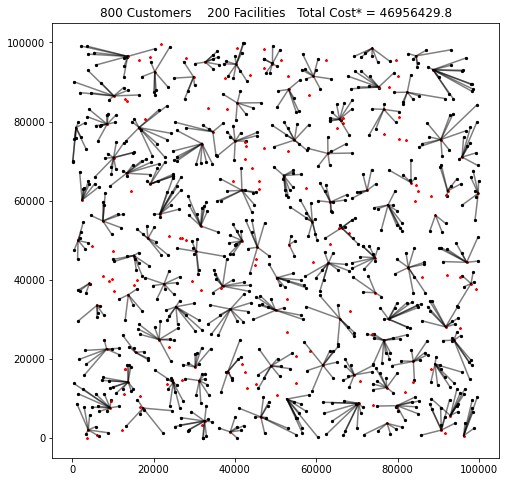

In [42]:
view_solution(solution,customers,facilities)

In [103]:
from algorithms import fix_allocations
fix_allocations(solution, customers,facilities)

## Divide and Conquer

In [131]:
#1  fl_25_2
#2  fl_50_6
#3  fl_100_7
#4  fl_100_1
#5  fl_200_7
#6  fl_500_7
#7  fl_1000_2
#8  fl_2000_2

1000 100


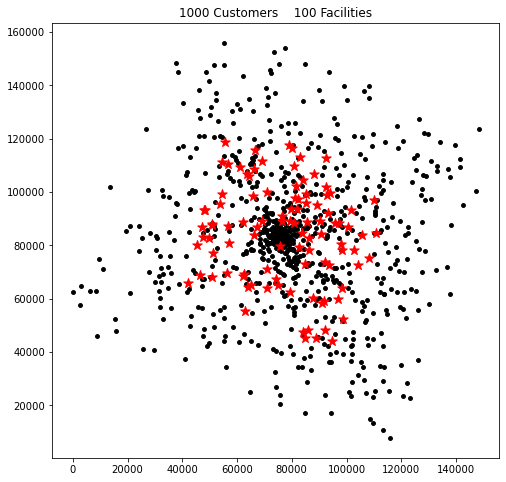

In [150]:
customers, facilities = load_data('fl_100_1')
n_cust = len(customers)
n_fac = len(facilities)
print(n_cust,n_fac)
view_problem(customers,facilities)

In [144]:
solution = cap_mip_gr(customers[:100],facilities,120)

Changed value of parameter TimeLimit to 120.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 202100 rows, 202000 columns and 800000 nonzeros
Model fingerprint: 0x304e4387
Variable types: 200000 continuous, 2000 integer (2000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [8e+01, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+03]
Found heuristic solution: objective 6006585.9047
Presolve time: 1.36s
Presolved: 202100 rows, 202000 columns, 801995 nonzeros
Variable types: 200000 continuous, 2000 integer (2000 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.10s

Solved with dual simplex

Root relaxation: objective 6.221099e+05, 2471 iterations, 0.61 seconds

    Nodes    |    Current Node    |     Object

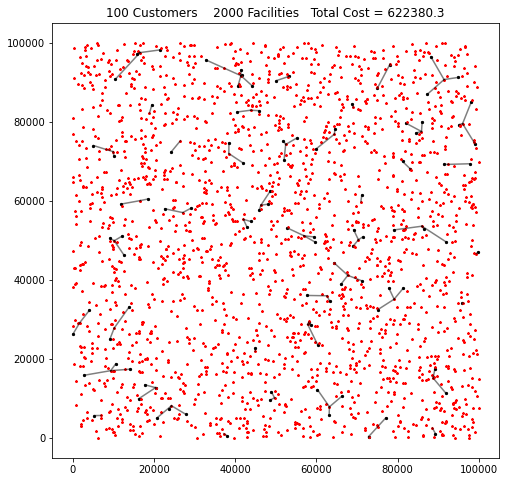

In [145]:
view_solution(solution,customers[:100],facilities)

In [155]:
def divide_conquer(customers,facilities,batch_size = 100):
    new_facilities = facilities.copy()
    solution = []
    for i in range(0,len(customers),batch_size):
        batch = customers[i:(i+100)]
        batch_sol = cap_mip_gr(batch,new_facilities,120)
        solution += [new_facilities[f].index for f in batch_sol]
        demands = [(f,batch[c].demand) for c,f in enumerate(batch_sol)]
        new_facilities = update_facilities(new_facilities,demands)
    return solution    

def update_facilities(facilities, demands):
    pass

In [135]:
import itertools

## Piecewise Solver

In [213]:
from gurobi_solver import cap_mip_gr

In [214]:
def get_grid_size(n_facilities, per_grid=100):
    for n in range(1, 10):
        if n_facilities / n**2 <= per_grid:
            return n
    else:
        return None


def is_inside(point, xrange, yrange):
    return xrange[0] < point.x < xrange[1] and yrange[0] < point.y < yrange[1]


def piecewise_mip(customers, facilities, per_grid=100, max_time = 60):
    n_cust = len(customers)
    n_fac = len(facilities)
    n = get_grid_size(n_fac,per_grid)
    x = [o.location.x for o in facilities + customers]
    y = [o.location.y for o in facilities + customers]
    xmin, xmax = min(x) - 1, max(x) + 1
    ymin, ymax = min(y) - 1, max(y) + 1
    xrange = np.linspace(xmin, xmax, n + 1)
    yrange = np.linspace(ymin, ymax, n + 1)
    allocations = []
    for i in range(n):
        xl = xrange[i]
        xu = xrange[i + 1]
        for j in range(n):
            print(f'*** Row#{i+1}/{n} Column#{j+1}/{n} ***')
            yl = yrange[j]
            yu = yrange[j+1]

            cgrid = [
                c for c in customers
                if is_inside(c.location, (xl, xu), (yl, yu))
            ]
            fgrid = [
                f for f in facilities
                if is_inside(f.location, (xl, xu), (yl, yu))
            ]

            solgrid = cap_mip_gr(cgrid, fgrid)
            try:
                validate(solgrid,cgrid,fgrid)
            except AssertionError:
                print('***************************')
                print('***  INVALID SOLUTION   ***')
                print('***************************')
            allocations += [(cgrid[c].index, fgrid[f].index)
                         for c, f in enumerate(solgrid)]
    solution = -np.ones(n_cust)
    for c,f in allocations:
        solution[c] = f
    return np.int32(solution)

In [204]:
#1  fl_25_2
#2  fl_50_6
#3  fl_100_7
#4  fl_100_1
#5  fl_200_7
#6  fl_500_7
#7  fl_1000_2
#8  fl_2000_2

3000 500


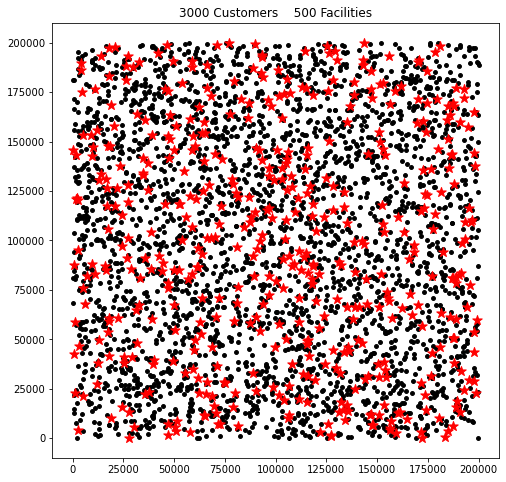

In [205]:
customers, facilities = load_data('fl_500_7')
n_cust = len(customers)
n_fac = len(facilities)
print(n_cust,n_fac)
view_problem(customers,facilities)

In [215]:
sol = piecewise_mip(customers, facilities, per_grid=80)

*** Row#1/3 Column#1/3 ***
Changed value of parameter TimeLimit to 60.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 17299 rows, 16954 columns and 67669 nonzeros
Model fingerprint: 0xba516123
Variable types: 0 continuous, 16954 integer (16954 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+03]
  Objective range  [4e+02, 9e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1.482907e+07
Presolve time: 0.06s
Presolved: 17299 rows, 16954 columns, 67669 nonzeros
Variable types: 0 continuous, 16954 integer (16954 binary)

Root relaxation: objective 3.206576e+06, 1494 iterations, 0.09 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3206576.32   

Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 20059 rows, 19720 columns and 78706 nonzeros
Model fingerprint: 0xbb3862ab
Variable types: 0 continuous, 19720 integer (19720 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+03]
  Objective range  [1e+02, 9e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1.514912e+07
Presolve time: 0.07s
Presolved: 20059 rows, 19720 columns, 78706 nonzeros
Variable types: 0 continuous, 19720 integer (19720 binary)

Root relaxation: objective 3.020385e+06, 1667 iterations, 0.09 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3020385.04    0  181 1.5149e+07 3020385.04  80.1%     -    0s
H    0     0                    3082983.9241 3020385.04  2.03%     -    0s
H    0     0                    3079335.7959 30203

Changed value of parameter TimeLimit to 60.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 20767 rows, 20416 columns and 81490 nonzeros
Model fingerprint: 0x1e57bef8
Variable types: 0 continuous, 20416 integer (20416 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+03]
  Objective range  [3e+02, 9e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1.569313e+07
Presolve time: 0.08s
Presolved: 20767 rows, 20416 columns, 81490 nonzeros
Variable types: 0 continuous, 20416 integer (20416 binary)

Root relaxation: objective 3.108751e+06, 1819 iterations, 0.13 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3108750.56    0  438 1.5693e+07 3108750.


Solution count 9: 3.1361e+06 3.13777e+06 3.1496e+06 ... 1.46044e+07

Optimal solution found (tolerance 1.00e-04)
Best objective 3.136100442411e+06, best bound 3.136100442411e+06, gap 0.0000%
*** Row#2/3 Column#2/3 ***
Changed value of parameter TimeLimit to 60.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 22749 rows, 22425 columns and 89493 nonzeros
Model fingerprint: 0x1805f37d
Variable types: 0 continuous, 22425 integer (22425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+03]
  Objective range  [6e+01, 9e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1.500222e+07
Presolve time: 0.09s
Presolved: 22749 rows, 22425 columns, 89493 nonzeros
Variable types: 0 continuous, 22425 integer (22425 binary)

Root relaxation: objective 2.880723e+06, 1964 iterations,

  1301  1042 3353326.81   23  354 3367174.85 3349440.56  0.53%  14.9   10s
H 1305   993                    3366512.7066 3349440.56  0.51%  16.6   11s
H 1306   944                    3365789.1964 3349440.56  0.49%  16.6   11s
H 1312   901                    3360115.0391 3349440.56  0.32%  16.5   13s
H 1316   859                    3359265.6489 3349440.56  0.29%  18.2   14s
  1325   865 3359265.65    8  338 3359265.65 3349440.56  0.29%  18.1   15s
H 1327   824                    3354987.2807 3349440.56  0.17%  18.0   16s
  1357   846 3354987.28   90  353 3354987.28 3349440.56  0.17%  20.8   20s

Cutting planes:
  Gomory: 7
  Cover: 8
  MIR: 46
  StrongCG: 31
  Flow cover: 8
  GUB cover: 6
  Inf proof: 9
  RLT: 1

Explored 9610 nodes (153405 simplex iterations) in 23.60 seconds
Thread count was 12 (of 12 available processors)

Solution count 10: 3.35499e+06 3.35927e+06 3.36012e+06 ... 3.37215e+06

Optimal solution found (tolerance 1.00e-04)
Best objective 3.354987280655e+06, best bound 3.

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2756250.02    0  184 1.2898e+07 2756250.02  78.6%     -    0s
H    0     0                    2824561.7850 2756250.02  2.42%     -    0s
H    0     0                    2788412.0820 2756250.02  1.15%     -    0s
H    0     0                    2786761.6108 2756250.02  1.09%     -    0s
H    0     0                    2784417.7456 2756250.02  1.01%     -    0s
     0     0 2761823.98    0  229 2784417.75 2761823.98  0.81%     -    0s
     0     0 2761823.98    0  184 2784417.75 2761823.98  0.81%     -    0s
H    0     0                    2783704.1756 2761823.98  0.79%     -    1s
     0     0 2766665.89    0  299 2783704.18 2766665.89  0.61%     -    1s
H    0     0                    2776428.5452 2766665.89  0.35%     -    1s
     0     0 2768845.06    0  299 2776428.55 2768845.06  0.27%     -    1s
     0     0 2769452.46    0  192 2776428.55 2769452.46  0.25%     -    1s
     0     0 2769452.4

H 3657  1143                    3195724.2437 3191595.65  0.13%  18.2   14s
H 3677   945                    3194911.9807 3191595.65  0.10%  18.2   14s
H 3846   848                    3194689.5343 3191822.88  0.09%  18.1   14s
  4578  1108     cutoff   36      3194689.53 3192407.65  0.07%  17.5   15s
H 7318  1226                    3194403.4925 3193129.16  0.04%  16.4   16s
H 7782   964                    3194311.8794 3193246.35  0.03%  16.4   16s

Cutting planes:
  Gomory: 11
  Cover: 11
  MIR: 63
  StrongCG: 35
  Flow cover: 9
  GUB cover: 11
  Inf proof: 23
  Zero half: 1
  RLT: 6

Explored 9251 nodes (160176 simplex iterations) in 16.86 seconds
Thread count was 12 (of 12 available processors)

Solution count 10: 3.19431e+06 3.1944e+06 3.19469e+06 ... 3.19681e+06

Optimal solution found (tolerance 1.00e-04)
Best objective 3.194311879396e+06, best bound 3.194311879396e+06, gap 0.0000%


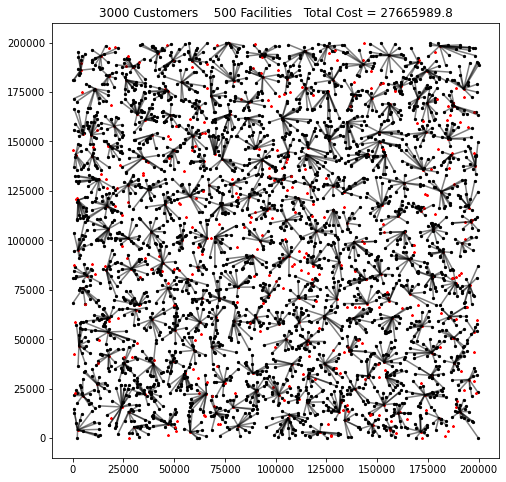

In [218]:
view_solution(sol,customers,facilities)